In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.naive_bayes import GaussianNB  # Replacing KNN with GNB
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, roc_auc_score
)
from sentence_transformers import SentenceTransformer



/Users/benjaminhinrichs/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/benjaminhinrichs/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class NBHateSpeechClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.25, model_name='all-MiniLM-L6-v2', precomputed=False):
        self.threshold = threshold
        self.model_name = model_name
        self.precomputed = precomputed
        self.embedder = SentenceTransformer(model_name)
        self.scaler = StandardScaler()
        self.nb = GaussianNB()  # Using GaussianNB instead of KNN

    def fit(self, X, y):
        if self.precomputed:
            X_scaled = self.scaler.fit_transform(X)
        else:
            X_emb = self.embedder.encode(X, show_progress_bar=False)
            X_scaled = self.scaler.fit_transform(X_emb)
        self.nb.fit(X_scaled, y)
        return self

    def predict_proba(self, X):
        if self.precomputed:
            X_scaled = self.scaler.transform(X)
        else:
            X_emb = self.embedder.encode(X, show_progress_bar=False)
            X_scaled = self.scaler.transform(X_emb)
        return self.nb.predict_proba(X_scaled)

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs[:, 1] >= self.threshold).astype(int)

    def get_embeddings(self, texts, scale=True):
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()
        embeddings = self.embedder.encode(texts, show_progress_bar=False)
        if scale:
            return self.scaler.fit_transform(embeddings)
        return embeddings

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Not Hate", "Hate"],
                    yticklabels=["Not Hate", "Hate"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    def show_misclassifications(self, X, y_true, y_pred):
        X = pd.Series(X)
        y_true = pd.Series(y_true)
        y_pred = pd.Series(y_pred)
        mismatches = X[y_true != y_pred]
        print("\nFALSE POSITIVES:")
        print(mismatches[(y_true == 0) & (y_pred == 1)].head(5).to_string(index=False))
        print("\nFALSE NEGATIVES:")
        print(mismatches[(y_true == 1) & (y_pred == 0)].head(5).to_string(index=False))


In [5]:
base_dir = os.getcwd()
test_path = os.path.join(base_dir, "../data/test_data_clean.csv")
train_path = os.path.join(base_dir, "../data/train_data.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()
test_texts = test_df["comment"].tolist()
test_labels = test_df["isHate"].tolist()


In [6]:
model = NBHateSpeechClassifier()
X_train = model.get_embeddings(train_texts, scale=True)
X_test = model.scaler.transform(model.embedder.encode(test_texts))

param_grid = {'threshold': [0.2, 0.3, 0.4, 0.5, 0.6]}
custom_scorer = make_scorer(f1_score)

grid = GridSearchCV(
    NBHateSpeechClassifier(precomputed=True),
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=3
)
grid.fit(X_train, train_labels)

print("Best Threshold:", grid.best_params_['threshold'])
best_model = grid.best_estimator_


/Users/benjaminhinrichs/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/benjaminhinrichs/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/benjaminhinrichs/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/benjaminhinrichs/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/Users/benjaminhinrichs/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
 

Best Threshold: 0.2


In [7]:
optimal_threshold = grid.best_params_['threshold']
test_labels_bin = (np.array(test_labels) >= optimal_threshold).astype(int)
probs = best_model.predict_proba(X_test)[:, 1]
custom_preds = (probs >= optimal_threshold).astype(int)

print(classification_report(test_labels_bin, custom_preds))

              precision    recall  f1-score   support

           0       0.66      0.73      0.69       474
           1       0.73      0.66      0.69       524

    accuracy                           0.69       998
   macro avg       0.69      0.69      0.69       998
weighted avg       0.69      0.69      0.69       998



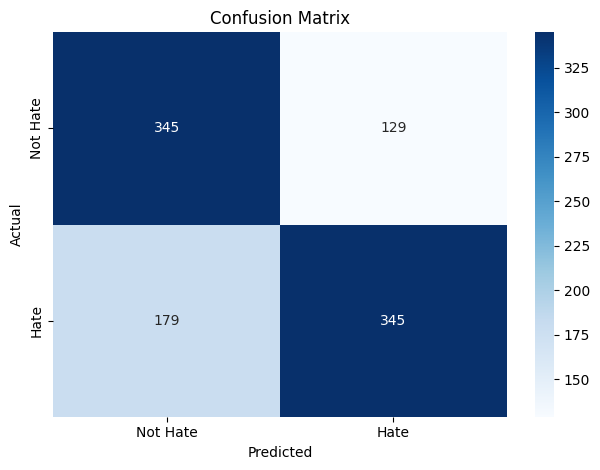


FALSE POSITIVES:
You guys I fell so bad, I hope this don’t happe...
               We are proud to be an Indian Muslim
To the lady that can barely speak English and t...
They are violent fucking savages what the fuck ...
             These people do not represent Islam!!

FALSE NEGATIVES:
   You look like Sloth with deeper Down’s syndrome
Why don’t you go beck your god to murder you? C...
Who do you think you are cunt? wtf! Stay steady...
Watching this kid trying to step up and walk wi...
                        U SUCK SHIT YOU BLACK FUCK


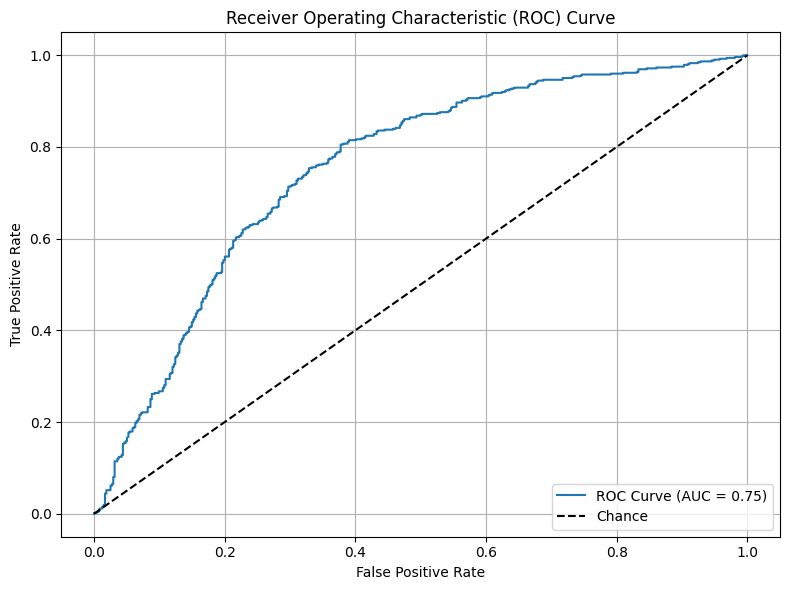

In [9]:
best_model.plot_confusion_matrix(test_labels_bin, custom_preds)
best_model.show_misclassifications(test_texts, test_labels_bin, custom_preds)

# ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(test_labels_bin, probs)
roc_auc = roc_auc_score(test_labels_bin, probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_labels_bin, probs)
avg_precision = average_precision_score(test_labels_bin, probs)



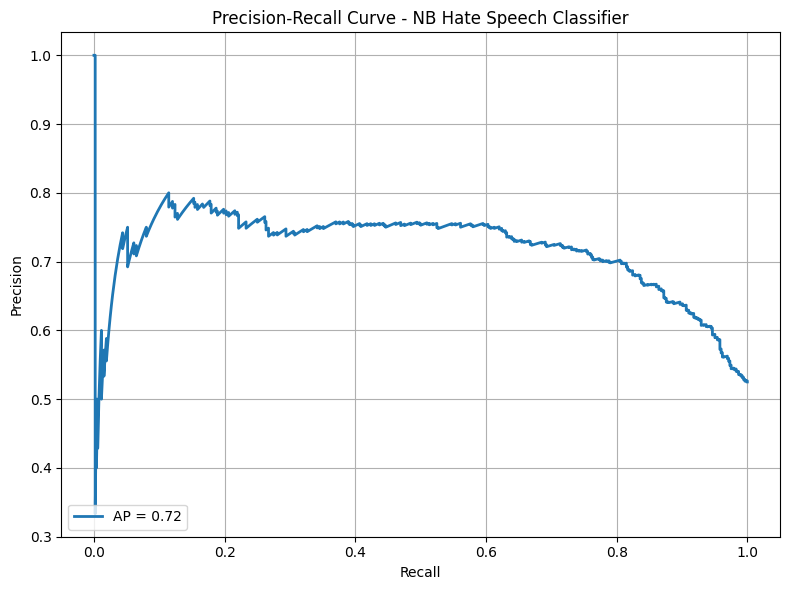

In [30]:
precision, recall, _ = precision_recall_curve(test_labels_bin, probs)
avg_precision = average_precision_score(test_labels_bin, probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - NB Hate Speech Classifier')  # Updated title
plt.grid(True)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()
